In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage
import os


In [42]:

# Configurar la autenticación con la clave de servicio JSON
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "proyectofinalgogleyelp-41e96ec7a40a.json"

# Nombre del bucket en GCS
bucket_name = "dataset-pf-gyelp"
destination_folder = ".\dataWorkingon"

# Lista de archivos a descargar
files = [
  "Yelp/processed/user_cleaned.csv",
  "Yelp/processed/reviews_cleaned.csv",
  "Yelp/processed/users_cleaned.csv",
  "Yelp/processed/tips_cleaned.csv",
  "Yelp/processed/review_cleaned.csv",
  "Yelp/processed/business_cleaned.csv"
]

# Inicializar cliente de almacenamiento
client = storage.Client()
bucket = client.bucket(bucket_name)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_32864\3218876022.py:6: SyntaxWarning: invalid escape sequence '\d'
  destination_folder = ".\dataWorkingon"


In [ ]:



# Descargar archivos
for file in files:
    blob = bucket.blob(file)
    destination_path = os.path.join(destination_folder, os.path.basename(file))
    blob.download_to_filename(destination_path)
    print(f"Descargado: {destination_path}")

print("✅ Descarga completada.")


<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_41924\2898949774.py:6: SyntaxWarning: invalid escape sequence '\d'
  destination_folder = ".\dataWorkingon"


Descargado: .\dataWorkingon\user_cleaned.csv
Descargado: .\dataWorkingon\reviews_cleaned.csv
Descargado: .\dataWorkingon\users_cleaned.csv
Descargado: .\dataWorkingon\tips_cleaned.csv
Descargado: .\dataWorkingon\review_cleaned.csv
Descargado: .\dataWorkingon\business_cleaned.csv
✅ Descarga completada.


In [3]:
# ✅ Definir la función primero
def load_csv(file_path):
    if os.path.exists(file_path):  # Verifica si el archivo existe
        return pd.read_csv(file_path)
    else:
        print(f"⚠️ Error: Archivo no encontrado -> {file_path}")
        return None  # Retorna None si el archivo no existe

# ✅ Luego, usarla para leer archivos
base_path = "dataWorkingon"

files = ["reviews_cleaned.csv",  "users_cleaned.csv",
         "tips_cleaned.csv", "tips_cleaned.csv", "review_cleaned.csv", "checkin_cleaned.csv", "user_cleaned.csv"]

# ✅ Asegurarse de que load_csv esté definida antes de usarla
dataframes = {file: load_csv(os.path.join(base_path, file)) for file in files}

# ✅ Revisar qué archivos se cargaron correctamente
for file, df in dataframes.items():
    if df is not None:
        print(f"✔️ {file} cargado con {len(df)} filas")


C:\Users\PC\AppData\Local\Temp\ipykernel_32864\3439868655.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


⚠️ Error: Archivo no encontrado -> dataWorkingon\checkin_cleaned.csv


C:\Users\PC\AppData\Local\Temp\ipykernel_32864\3439868655.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


✔️ reviews_cleaned.csv cargado con 6990282 filas
✔️ users_cleaned.csv cargado con 2105597 filas
✔️ tips_cleaned.csv cargado con 908915 filas
✔️ review_cleaned.csv cargado con 4559049 filas
✔️ user_cleaned.csv cargado con 1987897 filas


In [35]:

# 1️⃣ Revisar columnas y tipos de datos
def check_columns(dataframes):
    for name, df in dataframes.items():
        print(f"\n🔍 {name} - Columnas y tipos de datos:")
        print(df.dtypes)
        print("-" * 50)

# 2 def convert_types(dataframes):
def check_columns(dataframes):
    for name, df in dataframes.items():
        print(f"\n🔍 {name} - Columnas y tipos de datos:")
        print(df.dtypes)
        print("-" * 50)

def convert_types(dataframes):
    for name, df in dataframes.items():
        for col in df.columns:
            if df[col].dtype == "object":
                try:
                    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d", errors="coerce")
                except Exception as e:
                    print(f"⚠️ Error al convertir {col} en {name}: {e}")
            if df[col].dtype == "object" and df[col].nunique() < len(df) * 0.5:
                df[col] = df[col].astype("category")
            if col == "is_open":
                df[col] = df[col].astype(bool)
    print("✅ Tipos de datos convertidos correctamente.")

def process_missing_values(dataframes):
    for name, df in dataframes.items():
        numeric_df = df.select_dtypes(include=[np.number])
        for col in numeric_df.columns:
            mean = df[col].mean()
            df[col] = df[col].fillna(mean)
    print("✅ Valores nulos tratados correctamente.")

def expand_friends_column(dataframes):
    friends_dfs = {}
    for name, df in dataframes.items():
        if "friends" in df.columns and "user_id" in df.columns:
            friends_expanded = df[['user_id', 'friends']].dropna()
            friends_expanded = friends_expanded.assign(friends=friends_expanded["friends"].str.split(", "))
            friends_expanded = friends_expanded.explode("friends")
            friends_dfs[f"{name}_friends"] = friends_expanded
    dataframes.update(friends_dfs)
    print("✅ Columnas 'friends' transformadas correctamente.")

def expand_checkins_column(dataframes):
    if "checkins" in dataframes and "date" in dataframes["checkins"].columns:
        df = dataframes["checkins"]
        checkins_expanded = df[['business_id', 'date']].dropna()
        checkins_expanded = checkins_expanded.assign(date=checkins_expanded["date"].str.split(", "))
        checkins_expanded = checkins_expanded.explode("date")
        checkins_expanded["date"] = pd.to_datetime(checkins_expanded["date"], errors="coerce")
        dataframes["checkins_expanded"] = checkins_expanded
    print("✅ Columnas 'checkins' transformadas correctamente.")

def verify_transformation(dataframes):
    for name, df in dataframes.items():
        print(f"\n🔹 {name} - Primeras 5 filas:")
        print(df.head(5))
        print(f"\n🔹 {name} - Últimas 5 filas:")
        print(df.tail(5))
        print("-" * 50)

def plot_and_export(dataframes, output_path, bucket):
    os.makedirs(output_path, exist_ok=True)
    for name, df in dataframes.items():
        if not df.empty:
            numeric_df = df.select_dtypes(include=[np.number])
            for col in numeric_df.columns:
                plt.figure(figsize=(10, 5))
                sns.histplot(numeric_df[col], bins=30, kde=True)
                plt.axvline(numeric_df[col].mean(), color='r', linestyle='dashed', linewidth=2, label='Media')
                plt.title(f'Distribución de {col} en {name}')
                plt.legend()
                plt.show()
            
            csv_path = os.path.join(output_path, f"{name}.csv")
            feed_path = os.path.join(output_path, f"{name}.feed")
            
            df.to_csv(csv_path, index=False)
            df.to_pickle(feed_path)
            print(f"✔️ {name}.csv y {name}.feed guardados correctamente.")
            
            # Subir archivos a GCS en la subcarpeta ETL
            for file_path in [csv_path, feed_path]:
                blob = bucket.blob(f"ETL/{os.path.basename(file_path)}")
                blob.upload_from_filename(file_path)
                print(f"☁️ Archivo subido a GCS: ETL/{os.path.basename(file_path)}")






In [ ]:
# Cargar datos
dataframes = {}
base_path = "dataWorkingon"
files = ["reviews_cleaned.csv", "users_cleaned.csv", "tips_cleaned.csv", "review_cleaned.csv", "user_cleaned.csv"]
for file in files:
    file_path = os.path.join(base_path, file)
    if os.path.exists(file_path):
        df_name = file.replace(".csv", "")
        df = pd.read_csv(file_path)
        dataframes[df_name] = df


In [6]:
# Ejecutar el ETL en bloques
check_columns(dataframes)



🔍 reviews_cleaned - Columnas y tipos de datos:
review_id       object
user_id         object
business_id     object
stars          float64
useful         float64
funny          float64
cool           float64
text            object
date            object
dtype: object
--------------------------------------------------

🔍 users_cleaned - Columnas y tipos de datos:
user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
comp

In [9]:
print("Archivos cargados en dataframes:", list(dataframes.keys()))



Archivos cargados en dataframes: ['reviews_cleaned', 'users_cleaned', 'tips_cleaned', 'review_cleaned', 'user_cleaned']


In [10]:
def inspect_object_columns(dataframes):
    object_columns = {
        "reviews_cleaned": ["review_id", "user_id", "business_id", "text", "date"],
        "users_cleaned": ["user_id", "name", "elite", "friends", "yelping_since"],
        "tips_cleaned": ["user_id", "business_id", "text", "date"],
        "review_cleaned": ["review_id", "user_id", "business_id", "text", "date"],
        "user_cleaned": ["user_id", "name", "elite", "friends", "yelping_since"]
    }

    for file_name, columns in object_columns.items():
        df = dataframes.get(file_name)
        if df is not None:
            print(f"\n🔍 {file_name} - Inspección de valores únicos:")
            for col in columns:
                unique_values = df[col].dropna().unique()[:5]  # Muestra 5 valores únicos no nulos
                print(f"📌 {col}: {unique_values}")

# 📌 Llamar la función
inspect_object_columns(dataframes)


🔍 reviews_cleaned - Inspección de valores únicos:
📌 review_id: ['KU_O5udG6zpxOg-VcAEodg' 'BiTunyQ73aT9WBnpR9DZGw'
 'saUsX_uimxRlCVr67Z4Jig' 'AqPFMleE6RsU23_auESxiA'
 'Sx8TMOWLNuJBWer-0pcmoA']
📌 user_id: ['mh_-eMZ6K5RLWhZyISBhwA' 'OyoGAe7OKpv6SyGZT5g77Q'
 '8g_iMtfSiwikVnbP2etR0A' '_7bHUi9Uuf5__HHc_Q8guQ'
 'bcjbaE6dDog4jkNY91ncLQ']
📌 business_id: ['XQfwVwDr-v0ZS3_CbbE5Xw' '7ATYjTIgM3jUlt4UM3IypQ'
 'YjUWPpI6HXG530lwP-fb2A' 'kxX2SOes4o-D3ZQBkiMRfA'
 'e4Vwtrqf-wpJfwesgvdgxQ']
📌 text: ["If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicke

In [14]:
# Ejecutar el ETL en bloques

convert_types(dataframes)


✅ Tipos de datos convertidos correctamente.


In [19]:
process_missing_values(dataframes)


✅ Valores nulos tratados correctamente.


In [21]:
expand_friends_column(dataframes)

✅ Columnas 'friends' transformadas correctamente.


In [22]:
expand_checkins_column(dataframes)

✅ Columnas 'checkins' transformadas correctamente.


In [24]:
verify_transformation(dataframes)



🔹 reviews_cleaned - Primeras 5 filas:
                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0     0.0    0.0   0.0   
1    5.0     1.0    0.0   1.0   
2    3.0     0.0    0.0   0.0   
3    5.0     1.0    0.0   1.0   
4    4.0     1.0    0.0   1.0   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:

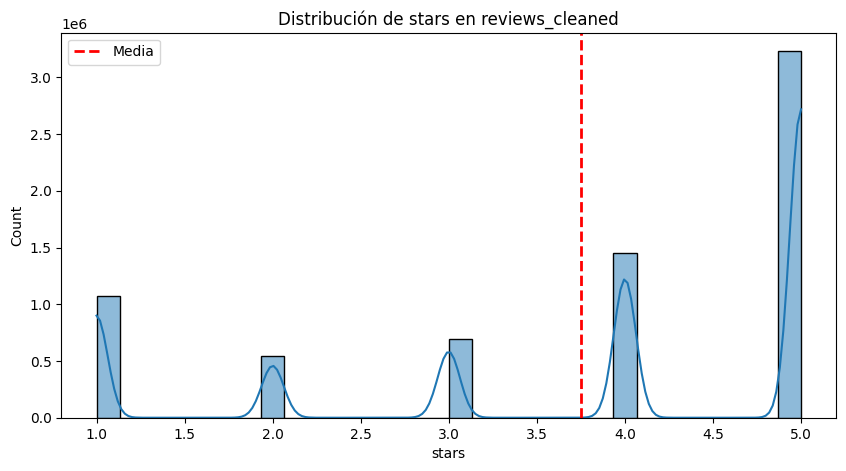

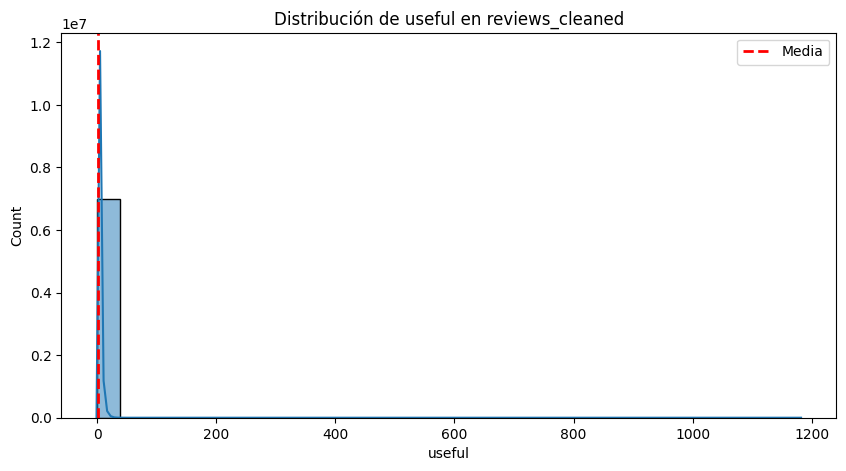

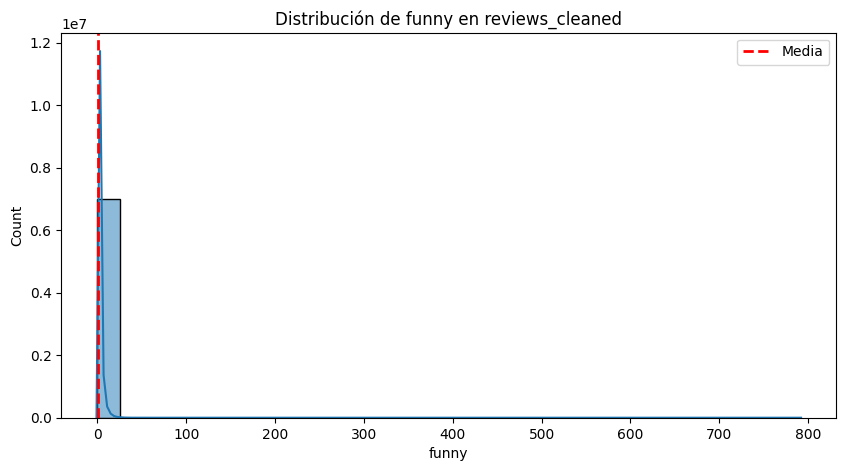

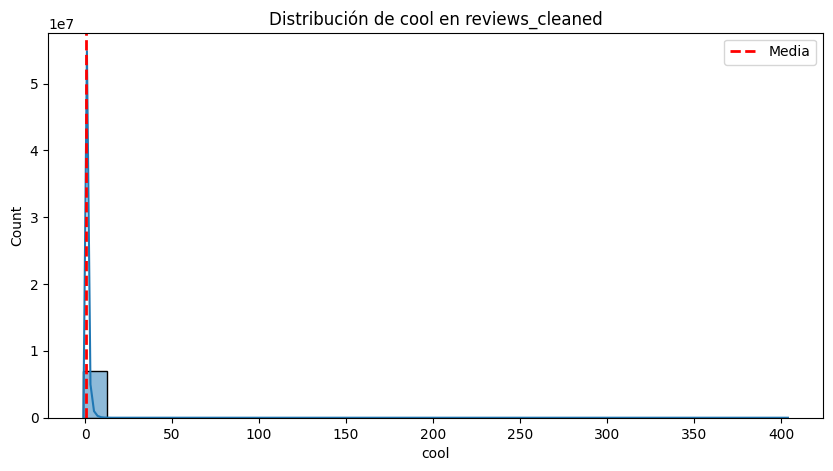

✔️ reviews_cleaned.csv y reviews_cleaned.feed guardados correctamente.


c:\Users\PC\Documents\Henry\PF\end\Lib\site-packages\google_crc32c\__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


☁️ Archivo subido a GCS: ETL/reviews_cleaned.csv
☁️ Archivo subido a GCS: ETL/reviews_cleaned.feed


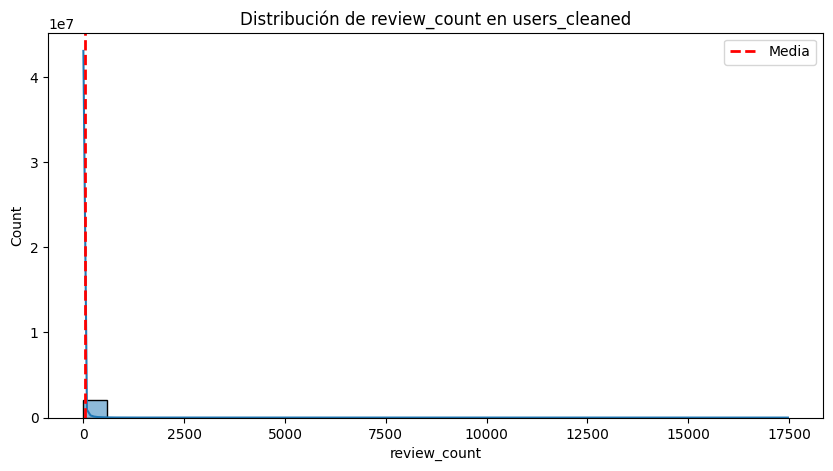

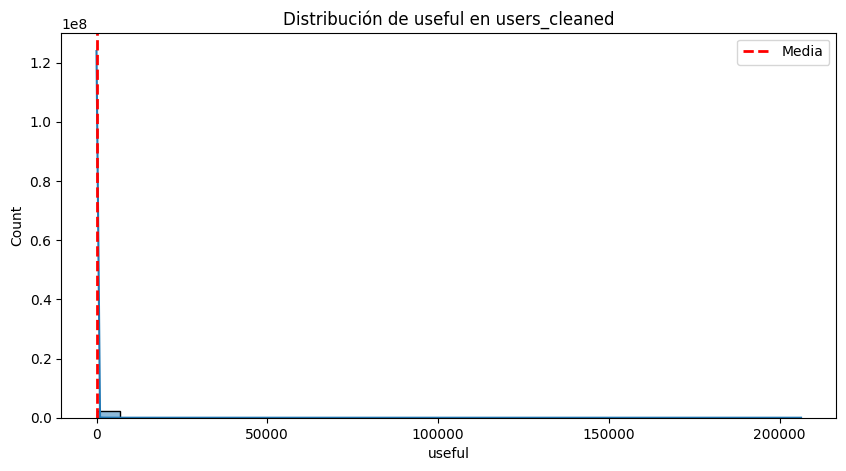

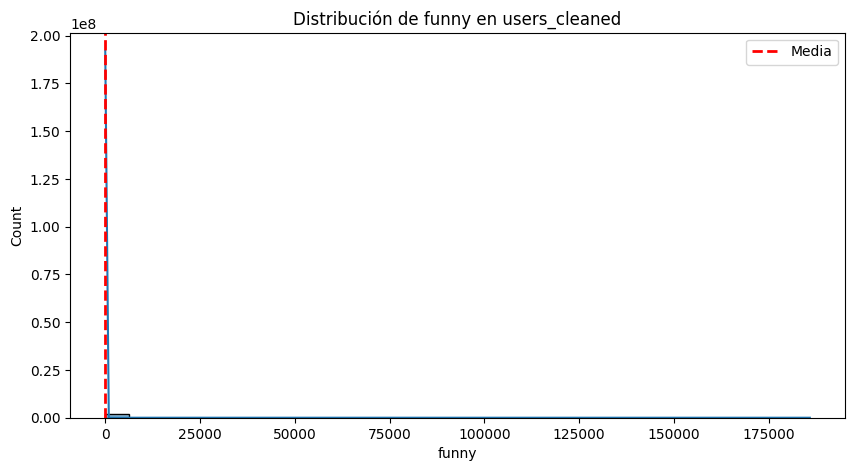

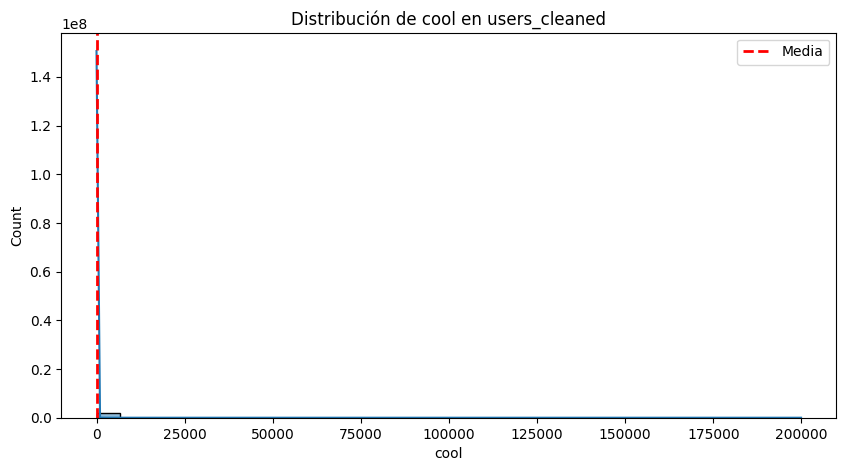

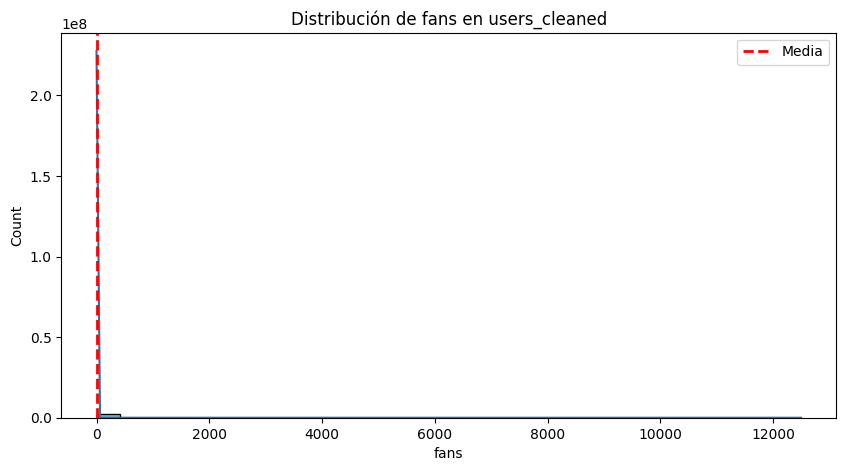

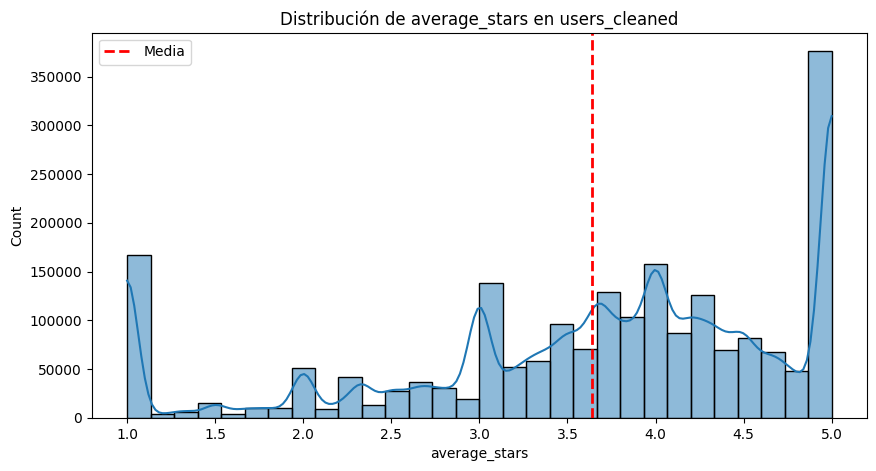

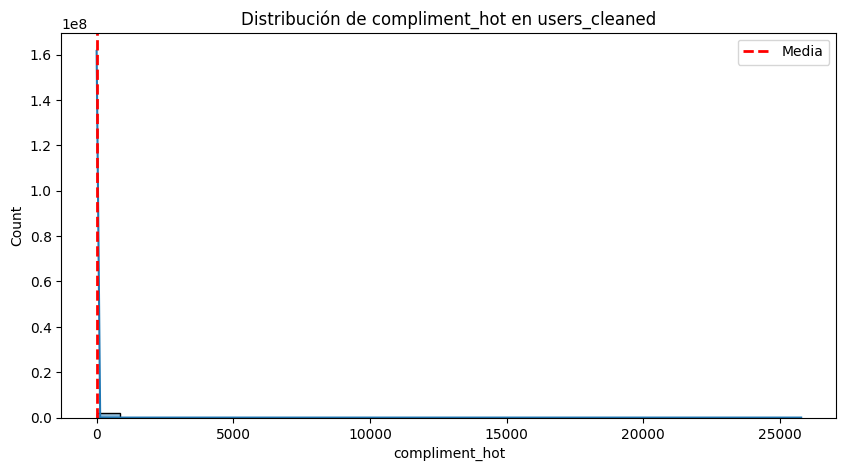

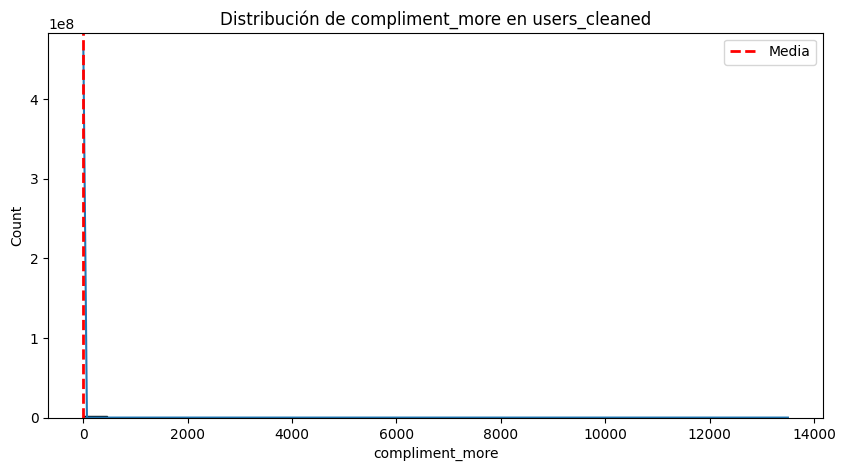

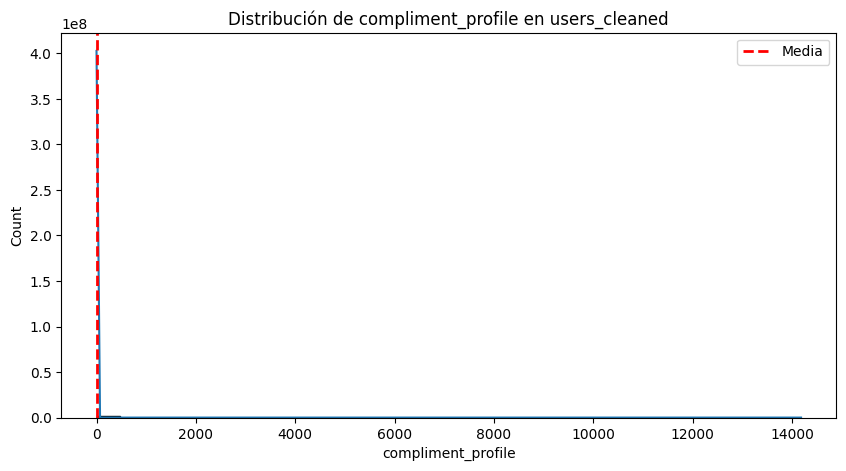

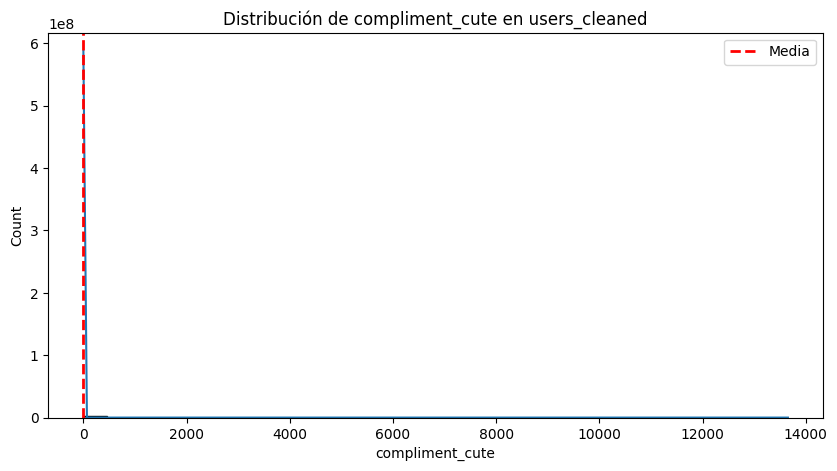

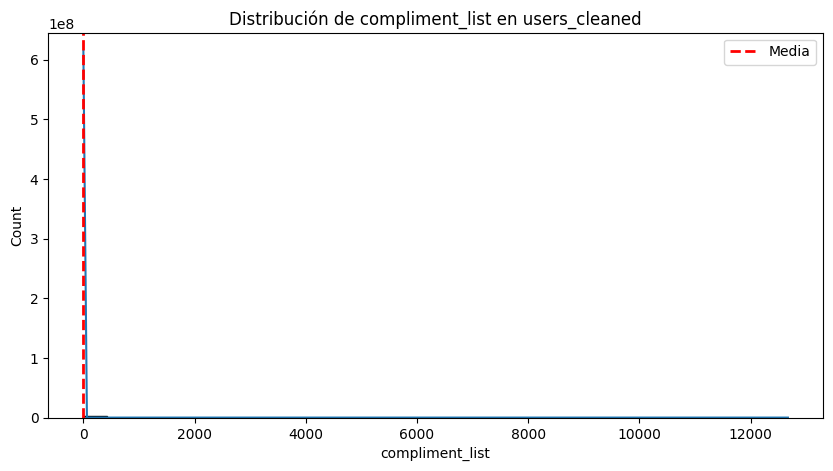

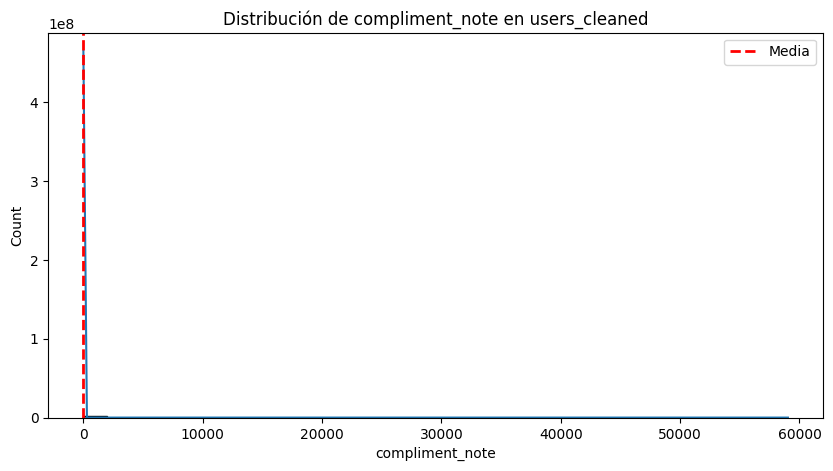

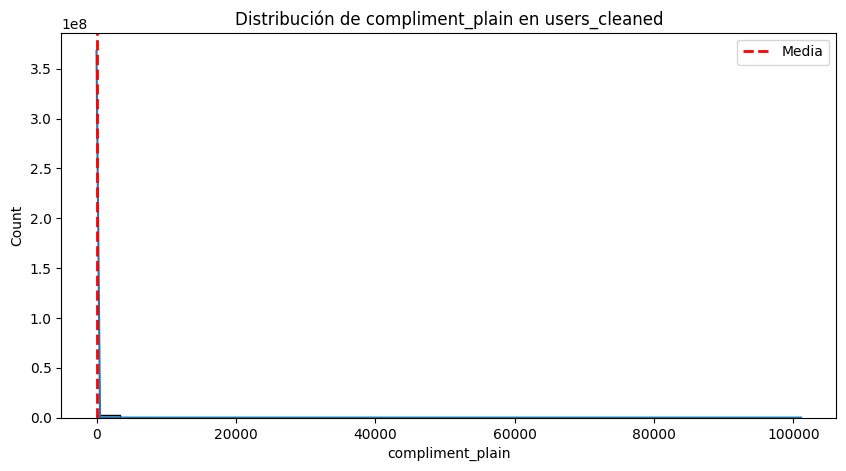

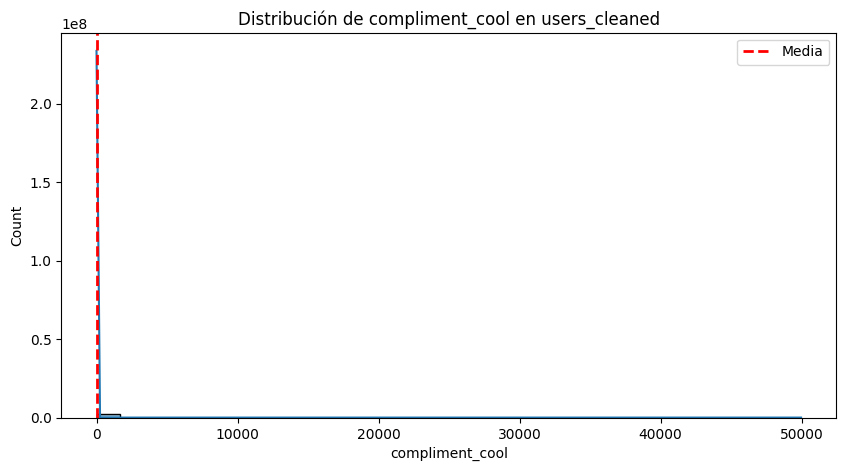

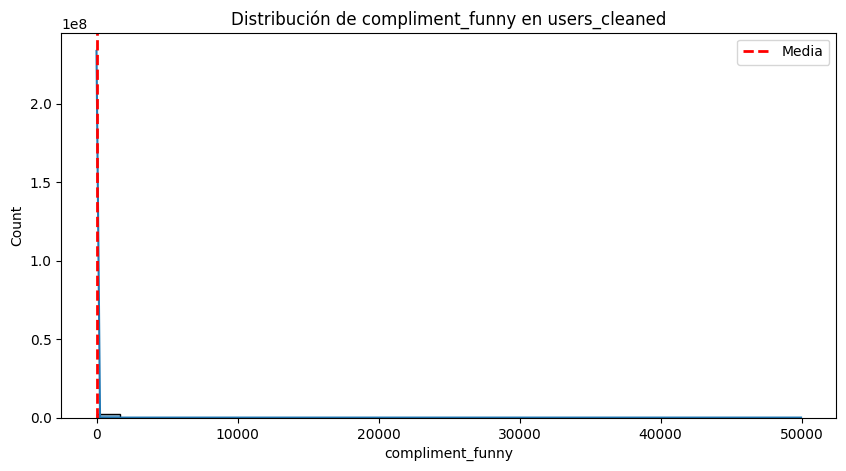

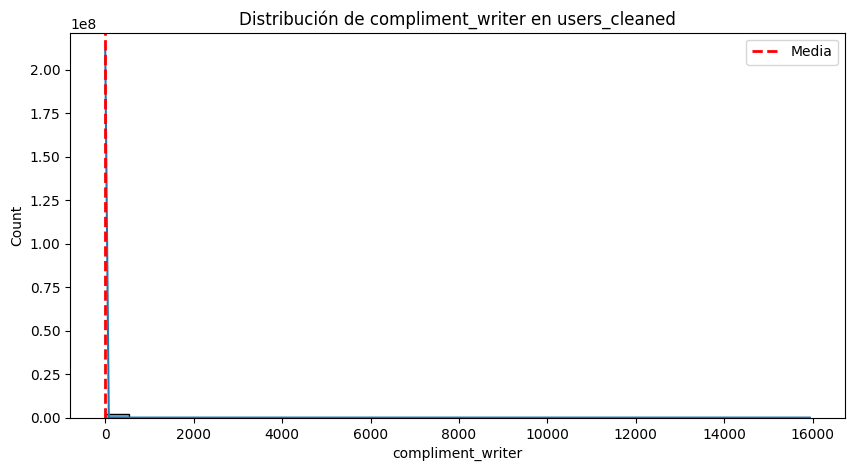

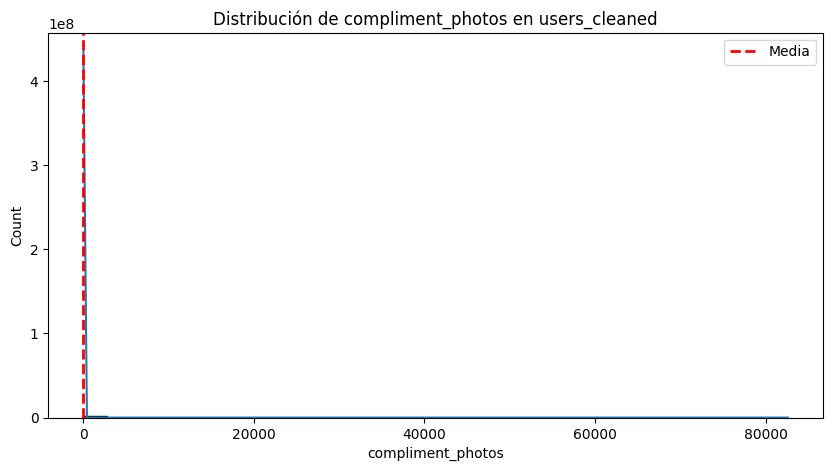

✔️ users_cleaned.csv y users_cleaned.feed guardados correctamente.
☁️ Archivo subido a GCS: ETL/users_cleaned.csv
☁️ Archivo subido a GCS: ETL/users_cleaned.feed


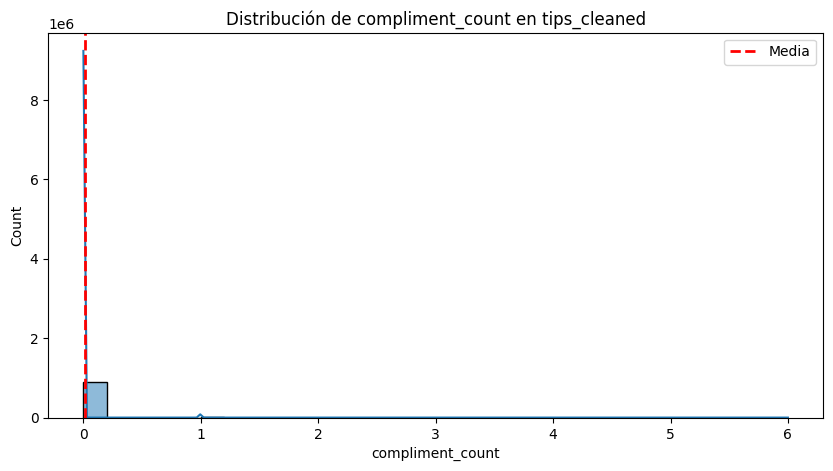

✔️ tips_cleaned.csv y tips_cleaned.feed guardados correctamente.
☁️ Archivo subido a GCS: ETL/tips_cleaned.csv
☁️ Archivo subido a GCS: ETL/tips_cleaned.feed


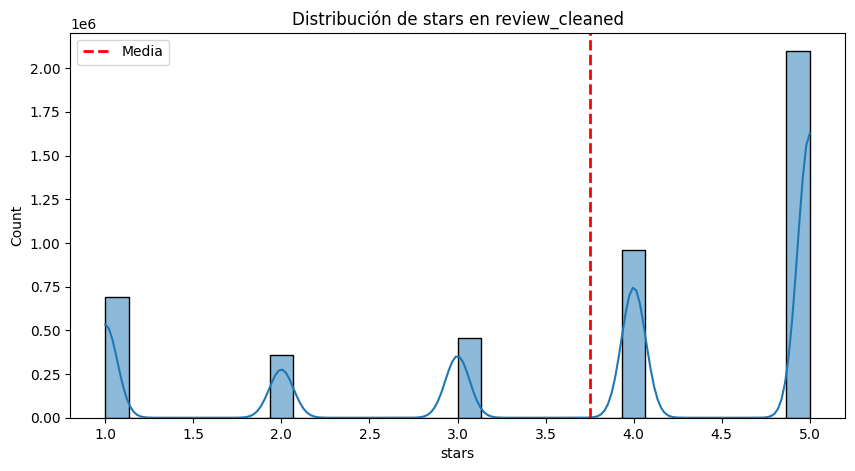

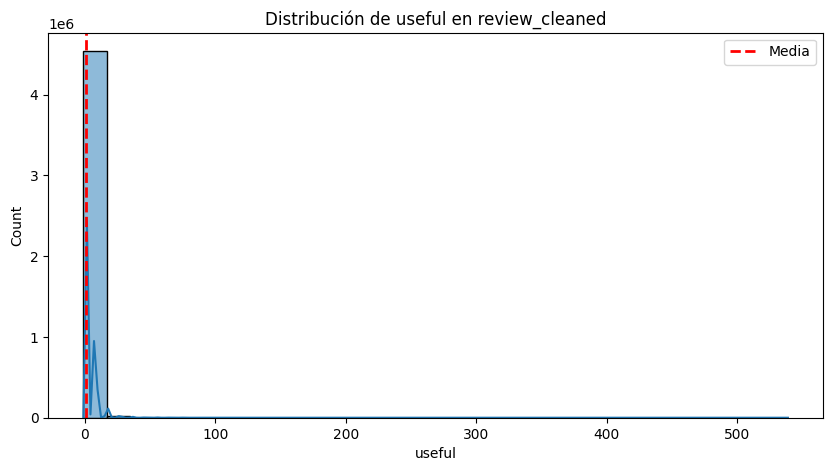

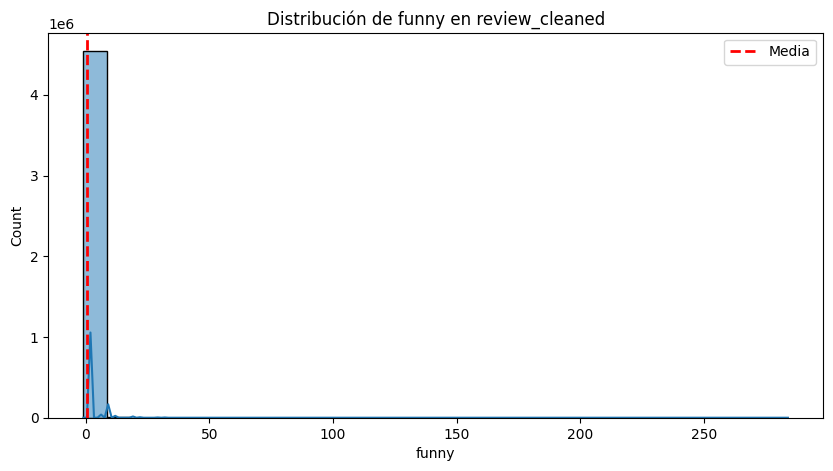

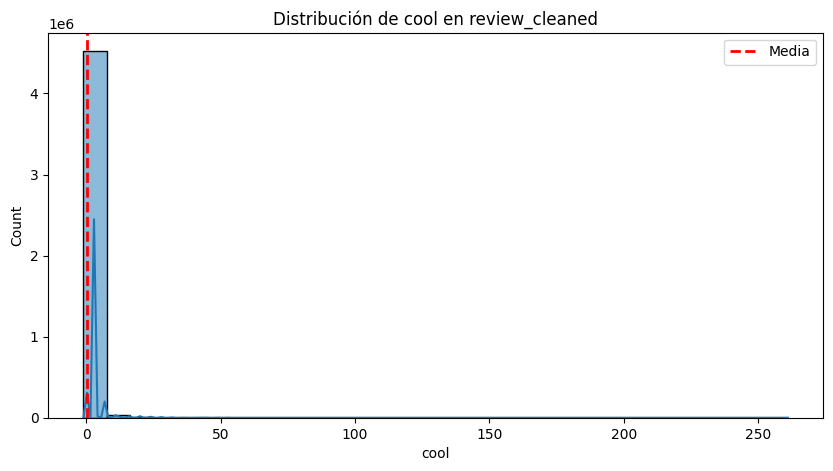

✔️ review_cleaned.csv y review_cleaned.feed guardados correctamente.
☁️ Archivo subido a GCS: ETL/review_cleaned.csv
☁️ Archivo subido a GCS: ETL/review_cleaned.feed


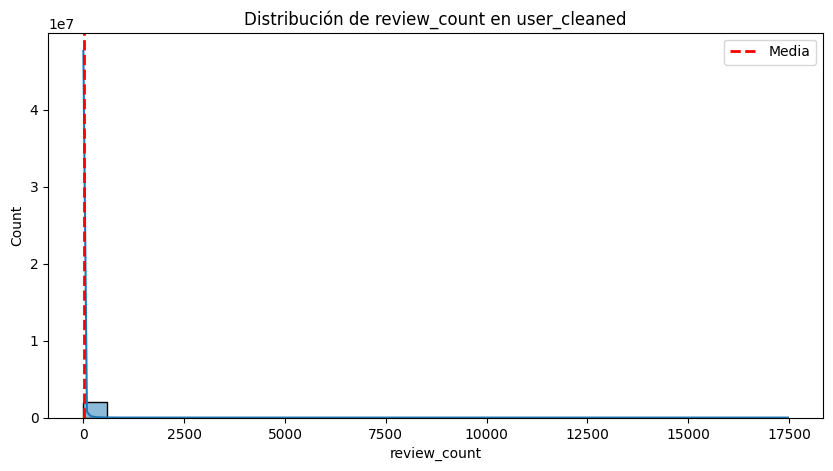

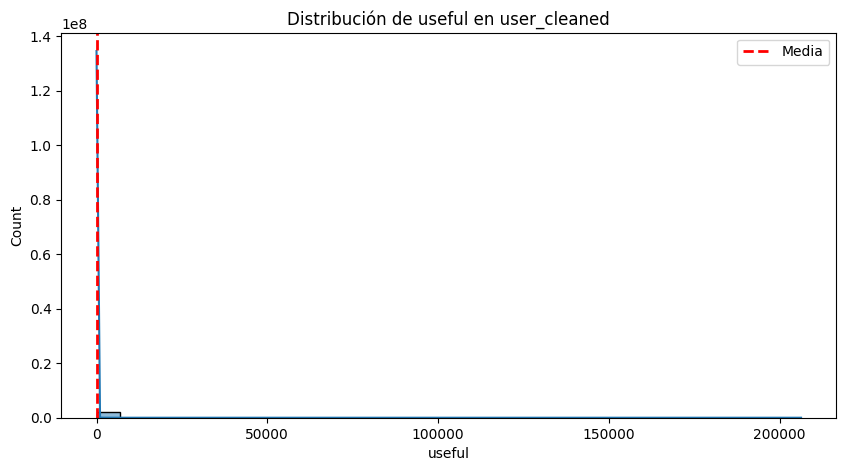

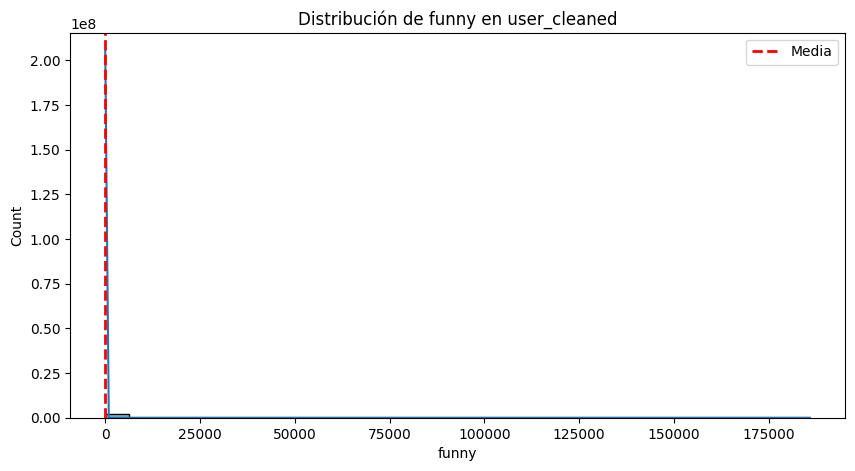

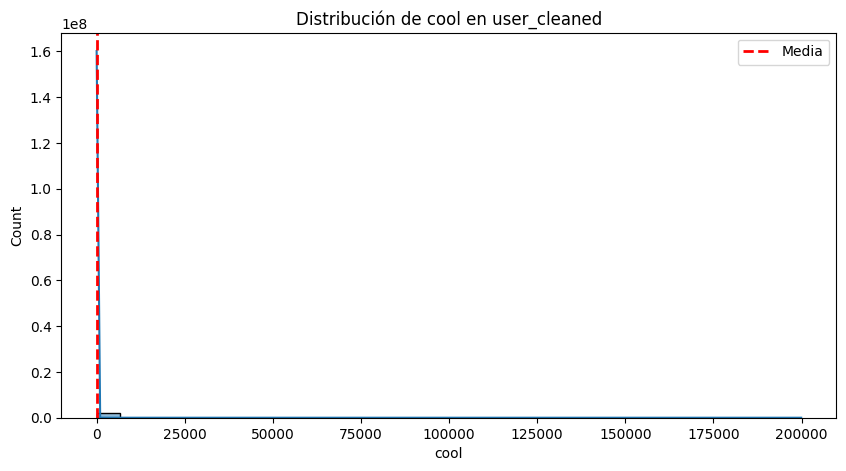

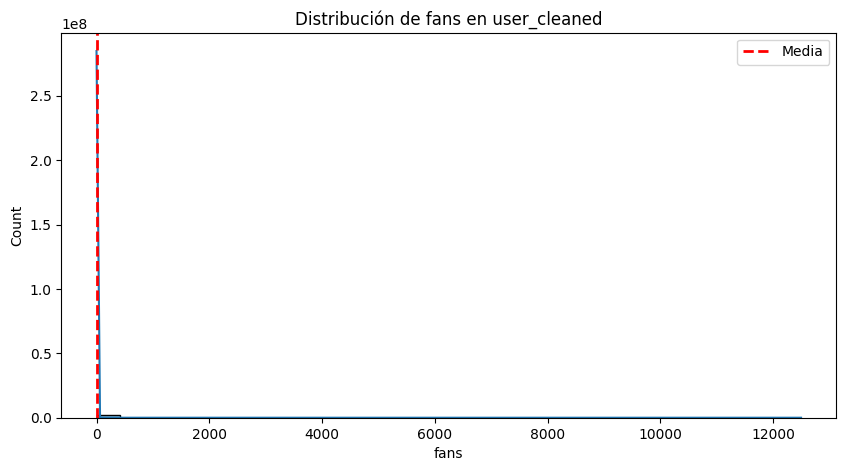

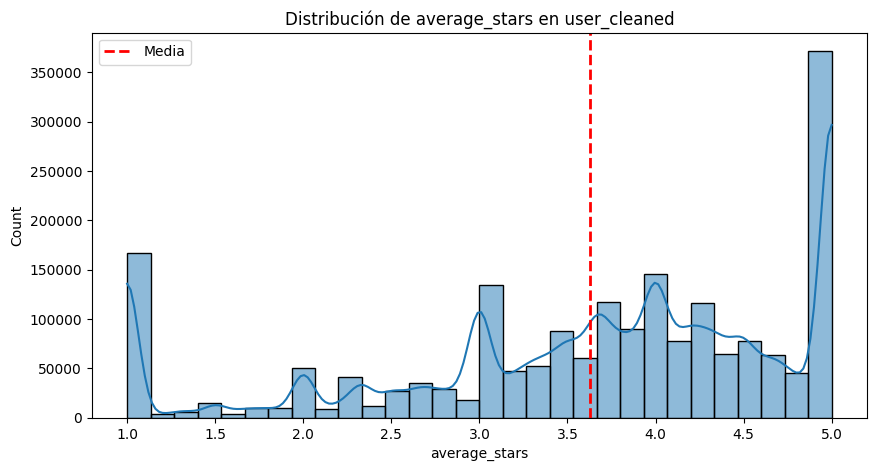

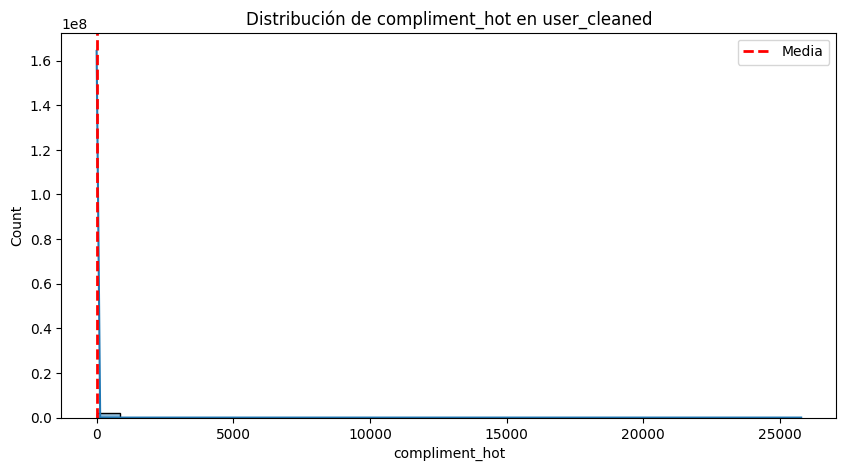

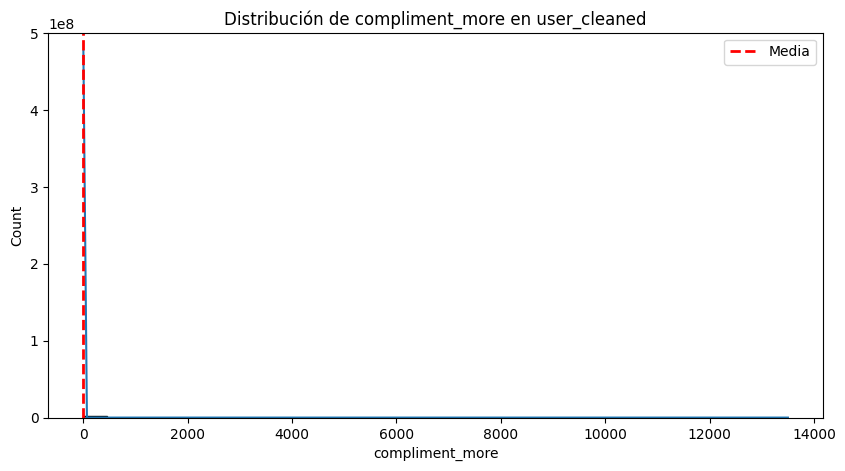

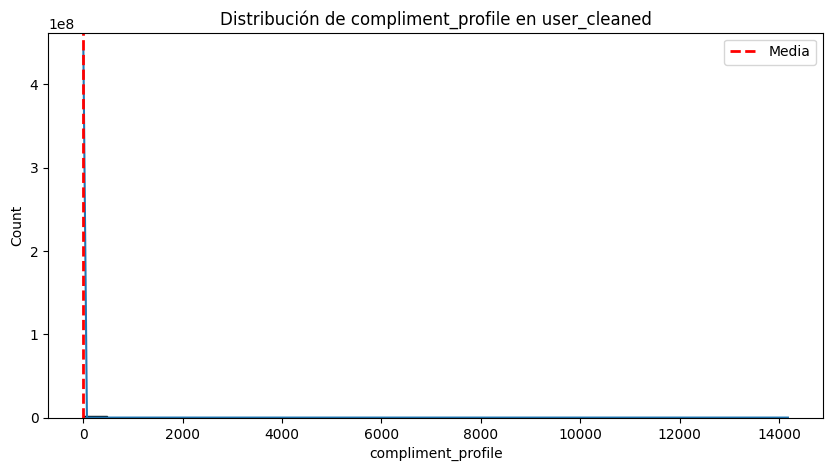

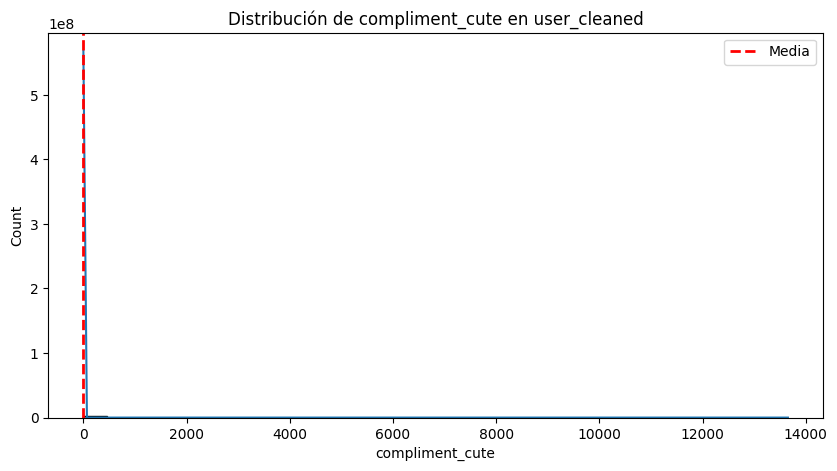

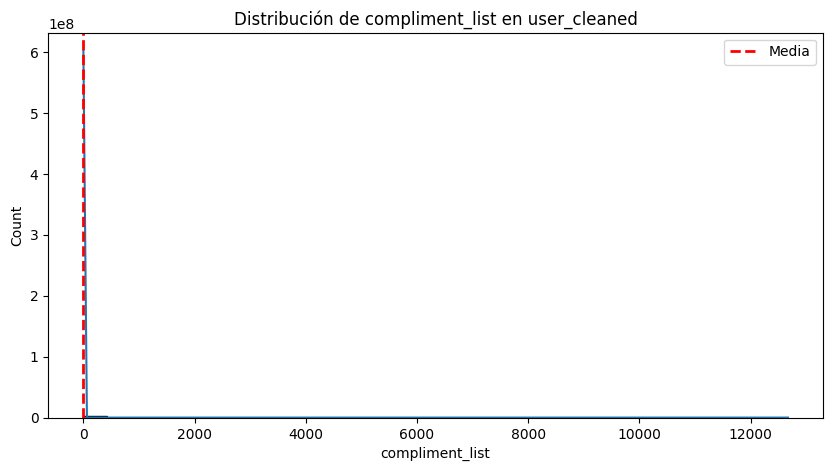

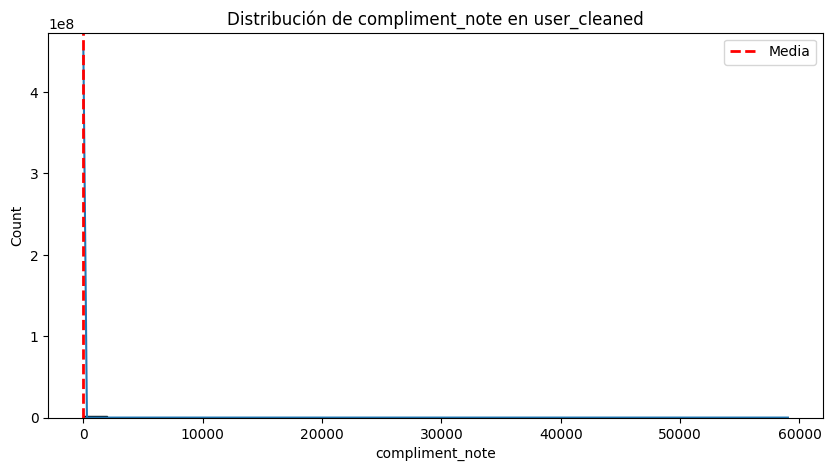

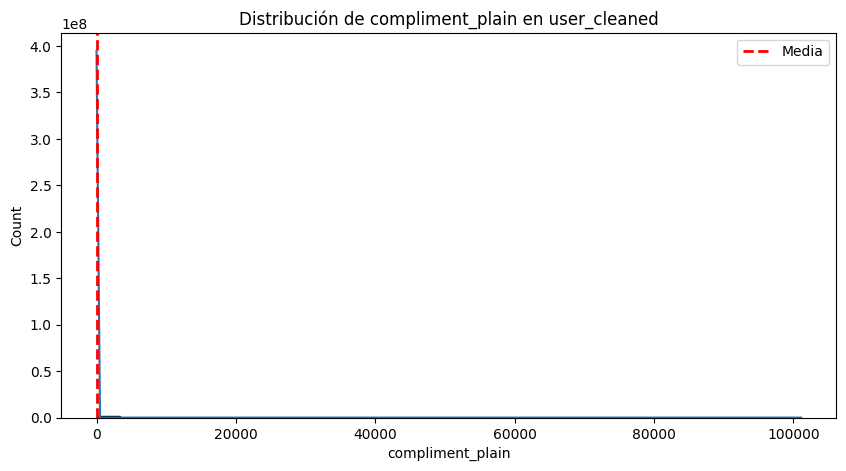

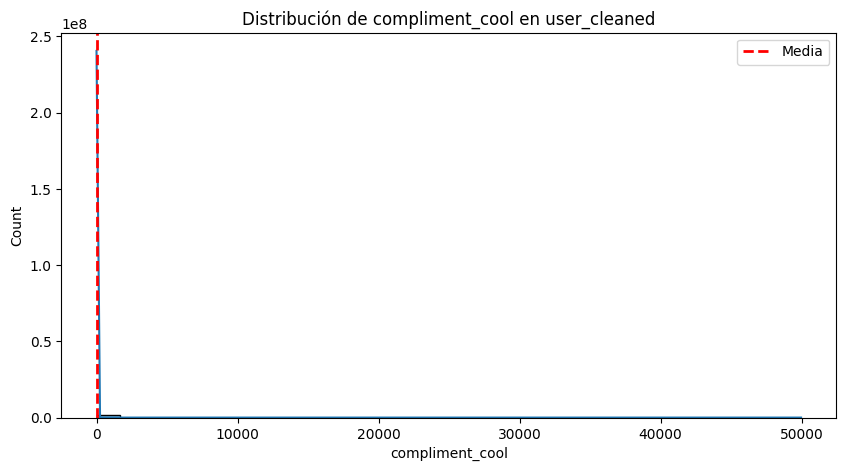

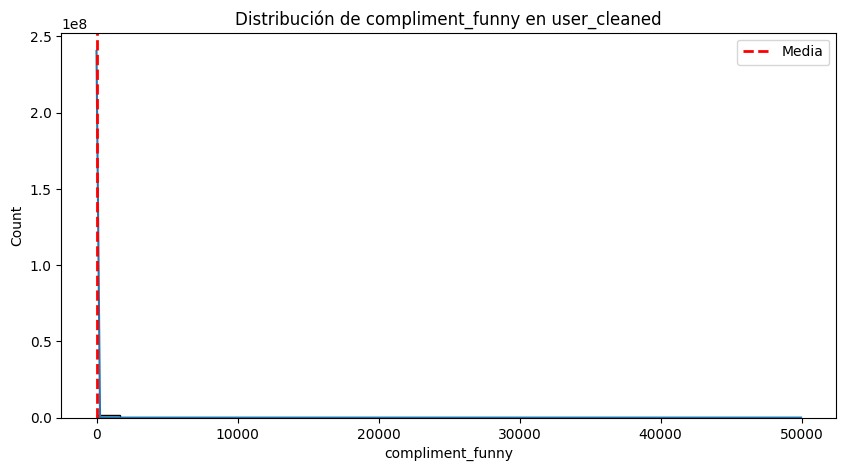

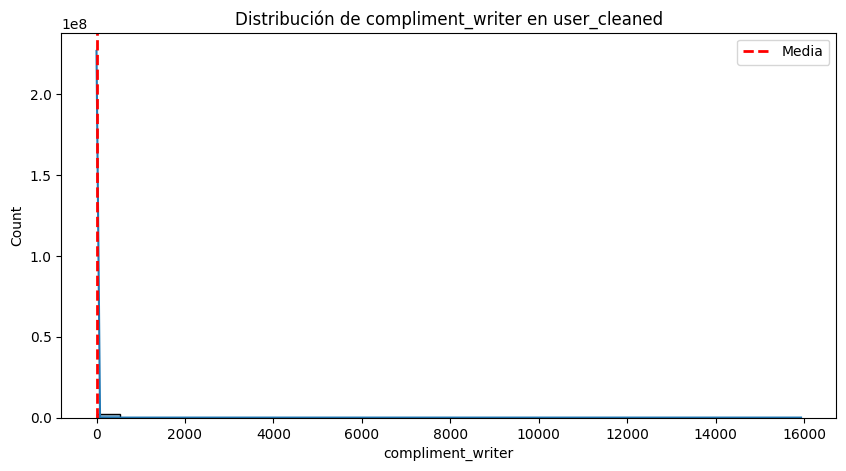

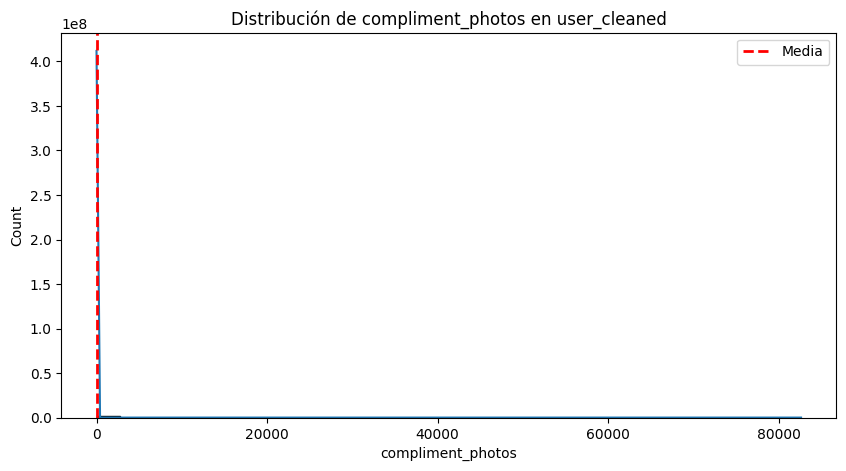

✔️ user_cleaned.csv y user_cleaned.feed guardados correctamente.
☁️ Archivo subido a GCS: ETL/user_cleaned.csv


In [ ]:
# Llamar la función pasando el bucket como argumento
bucket_name = "dataset-pf-gyelp"
plot_and_export(dataframes, "output_data",  bucket)

In [ ]:
# Función para analizar datos y detectar valores atípicos
def analyze_data(df, title):
    print(f"\n🔹 Análisis de {title}")
    
    # Mostrar columnas y tipos de datos
    print("\nColumnas y tipos de datos:")
    print(df.dtypes)
    
    # Contar valores nulos por columna
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
    
    # Filtrar columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty:
        print("⚠️ No hay columnas numéricas en este DataFrame.")
        return

    print(numeric_df.describe())  # Estadísticas generales

    std_dev = numeric_df.std()
    variance = numeric_df.var()
    print("\nDesviación estándar:\n", std_dev)
    print("\nVarianza:\n", variance)
    
    # Gráfico de distribución
    for col in numeric_df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(numeric_df[col], bins=30, kde=True)
        plt.axvline(numeric_df[col].mean(), color='r', linestyle='dashed', linewidth=2, label='Media')
        plt.axvline(numeric_df[col].mean() + std_dev[col], color='g', linestyle='dashed', linewidth=2, label='Media + 1σ')
        plt.axvline(numeric_df[col].mean() - std_dev[col], color='g', linestyle='dashed', linewidth=2, label='Media - 1σ')
        plt.title(f'Distribución de {col} en {title}')
        plt.legend()
        plt.show()

# Cargar datos
dataframes = {}
base_path = "dataWorkingon"
files = ["reviews_cleaned.csv", "business_cleaned.csv", "users_cleaned.csv", 
         "tips_cleaned.csv", "tip_cleaned.csv", "review_cleaned.csv", "checkin_cleaned.csv"]

for file in files:
    file_path = os.path.join(base_path, file)
    if os.path.exists(file_path):
        df_name = file.replace(".csv", "")
        df = pd.read_csv(file_path)
        dataframes[df_name] = df

# Aplicar análisis y transformación
db_path = "prepared_data"
os.makedirs(db_path, exist_ok=True)

for name, df in dataframes.items():
    analyze_data(df, name)
    
    # Manejo de valores nulos usando la media + ruido basado en la desviación estándar
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col].fillna(np.random.normal(mean, std), inplace=True)
    
    # Corrección de tipos de datos
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])  # Intentar convertir a fecha
            except:
                df[col] = df[col].astype(str)  # Mantener como string si no es fecha
        
    # Guardado en formato Feather
    feather_path = os.path.join(db_path, f"{name}.feather")
    df.to_feather(feather_path)
    print(f"✔️ {name}.feather guardado correctamente con {df.shape[0]} filas y {df.shape[1]} columnas.")
